# Import the necessary dependencies 

### Setting TensorFlow 2.x as default version 

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

### Importing the Visualisation and Preprocessing packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import cv2

import numpy as np
import pandas as pd
import pickle

import random


### Importing the TensorFlow dependencies

In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Data loading and Visualisation 

### Loading the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#data = pd.read_csv("german-traffic-signs / signnames.csv") 
  
with open('/content/drive/My Drive/Image Classification/train.pickle', 'rb') as f: 
    train_data = pickle.load(f) 
with open('/content/drive/My Drive/Image Classification/valid.pickle', 'rb') as f: 
    val_data = pickle.load(f) 
with open('/content/drive/My Drive/Image Classification/test.pickle', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
x_train, y_train = train_data['features'], train_data['labels'] 
x_val, y_val = val_data['features'], val_data['labels'] 
x_test, y_test = test_data['features'], test_data['labels'] 

print(x_train.shape) 
print(x_val.shape) 
print(x_test.shape) 

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


# Image Processing & Image Augmentation

### Pre-processing the images using OpenCV

In [7]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
x_train_final = np.array(list(map(preprocessing, x_train))) 
x_val_final = np.array(list(map(preprocessing, x_val))) 
x_test_final = np.array(list(map(preprocessing, x_test))) 
  
x_train_final = x_train_final.reshape(34799, 32, 32, 1) 
x_val_final = x_val_final.reshape(4410, 32, 32, 1) 
x_test_final = x_test_final.reshape(12630, 32, 32, 1) 


### Image Augmentation using ImageDataGenerator

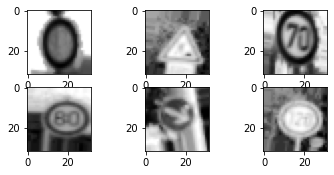

In [8]:

datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 

datagen.fit(x_train_final) 

#os.makedirs('/content/drive/My Drive/Image Classification/images')

for x_batch,y_batch in datagen.flow(x_train_final,y_train,batch_size=6,save_to_dir='/content/drive/My Drive/Image Classification/images',save_prefix='img', save_format='jpg'):
    for i in range(0, 6):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))

    plt.show()
    break

y_train = to_categorical(y_train, 43) 
y_val = to_categorical(y_val, 43) 
y_test = to_categorical(y_test, 43) 


# Model Building and Testing 

### Implementing the CNN Model 

In [9]:
def build_model(hp):
    model = Sequential()

    # Layer 1 
    model.add(Conv2D(filters=hp.Int('CONV_1_FILTER',min_value=32, max_value=64),
                     kernel_size=hp.Choice('KERNEL_1_FILTER', values=[3,5]),
                     activation='relu',
                     input_shape=(32,32,1), 
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_1', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    # Layer 2 
    model.add(Conv2D(filters=hp.Int('CONV_2_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_2_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


    # Layer 3
    model.add(Conv2D(filters=hp.Int('CONV_3_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_3_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_3', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    model.add(Flatten())

    
    model.add(Dense(hp.Int('DENSE_1_LAYER', 
                           min_value=32, 
                           max_value=512),
                    
                    activation = hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
    ))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    model.add(Dense(43, activation='softmax'))

    # Learning Rate set between 0.0001 to 0.01
    model.compile(Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG')),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

### Install Keras-tuner

In [10]:
!pip install keras-tuner

### Use RandomSearch using kerastuner to find the best hyperparameters

In [11]:
from kerastuner import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [12]:
tuner = RandomSearch(build_model, objective='val_accuracy',
                     max_trials = 10, 
                     directory='/content/drive/My Drive/Image Classification',
                     project_name="Image Classification")

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Image Classification/Image Classification/oracle.json


In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
CONV_1_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': None}
KERNEL_1_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
CONV_2_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': None}
KERNEL_2_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
CONV_3_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': None}
KERNEL_3_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 

In [14]:
tuner.search(x_train_final,y_train,epochs=50, validation_data=(x_val_final,y_val))

Trial 10 Complete [00h 11m 23s]
val_accuracy: 0.054421767592430115

Best val_accuracy So Far: 0.982086181640625
Total elapsed time: 01h 38m 42s
INFO:tensorflow:Oracle triggered exit


### Get the best model

In [15]:
final_model = tuner.get_best_models(num_models=1)[0]

In [16]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 50)        500       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 50)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 108)       48708     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 108)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 108)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 41)          3

### Creating a Model Checkpoint

In [17]:
filepath="/content/drive/My Drive/Image Classification/Model_CNN.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

### Fit the model

In [18]:
BATCH_SIZE = 100
EPOCHS = 40

In [19]:
history = final_model.fit(
                            datagen.flow(x_train_final, y_train, batch_size=BATCH_SIZE), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(BATCH_SIZE))), 
                            epochs = EPOCHS, 
                            validation_data =(x_val_final, y_val),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )


Epoch 1/40
348/348 [==============================] - 19s 52ms/step - loss: 0.7775 - accuracy: 0.8038 - val_loss: 0.1638 - val_accuracy: 0.9798

Epoch 00001: val_accuracy improved from -inf to 0.97982, saving model to /content/drive/My Drive/Image Classification/Model_CNN.hdf5
Epoch 2/40
348/348 [==============================] - 18s 51ms/step - loss: 0.5612 - accuracy: 0.8572 - val_loss: 0.1546 - val_accuracy: 0.9850

Epoch 00002: val_accuracy improved from 0.97982 to 0.98503, saving model to /content/drive/My Drive/Image Classification/Model_CNN.hdf5
Epoch 3/40
348/348 [==============================] - 18s 52ms/step - loss: 0.4879 - accuracy: 0.8811 - val_loss: 0.1516 - val_accuracy: 0.9878

Epoch 00003: val_accuracy improved from 0.98503 to 0.98776, saving model to /content/drive/My Drive/Image Classification/Model_CNN.hdf5
Epoch 4/40
348/348 [==============================] - 18s 52ms/step - loss: 0.4497 - accuracy: 0.8914 - val_loss: 0.1545 - val_accuracy: 0.9864

Epoch 00004: va

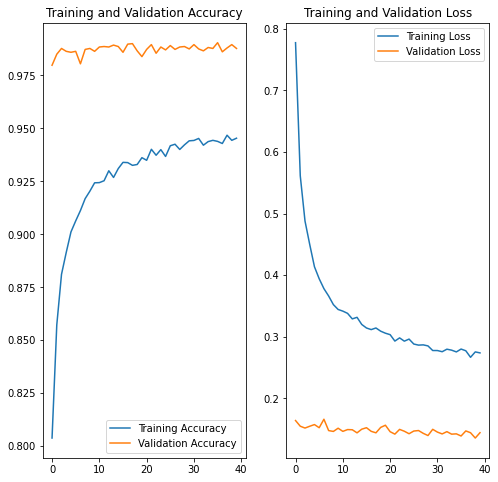

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Load the model's weights and biases for evaluation on Test set

In [21]:
final_model.load_weights("/content/drive/My Drive/Image Classification/Model_CNN.hdf5")
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
Pred_conv = final_model.evaluate(x_test_final, y_test, verbose=0)
print("Results on the test data")
print(" ")
print("%s- %.2f" % (final_model.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % (final_model.metrics_names[1], Pred_conv[1]))

Results on the test data
 
loss- 0.20
accuracy- 0.97


### Testing the model on the test dataset

Predicted sign: [[3.73254969e-11 1.55776688e-05 1.56375457e-09 6.48966081e-09
  1.61142662e-11 2.36373944e-06 9.99969840e-01 3.85586396e-10
  7.94638552e-13 8.40514588e-14 2.11972020e-11 1.57016691e-11
  2.99622306e-13 6.50864432e-11 8.37654666e-14 5.02504895e-12
  9.11926534e-10 3.34239709e-15 9.77660769e-13 2.76983785e-13
  3.46889103e-13 3.72449298e-14 3.47349916e-13 5.00484474e-13
  6.35445852e-13 3.31955088e-11 7.02899026e-15 9.84272993e-13
  2.71280177e-12 3.00932846e-12 6.85950574e-10 1.95450494e-13
  1.38566945e-08 2.77597025e-11 3.67685130e-13 1.54643551e-13
  4.64037500e-13 7.44419717e-12 4.74125357e-11 2.77368545e-10
  7.50485174e-10 1.19079857e-07 1.20255099e-05]]
---------------------------------------------------------------------------
Predicted Sign[[9.85855520e-01 1.76757414e-04 2.09822872e-07 1.27807070e-07
  1.02818805e-04 1.36508629e-06 1.23647581e-08 9.88352781e-07
  1.38620529e-02 7.17299165e-10 4.51670212e-12 6.09224924e-14
  6.97686199e-14 9.29678494e-14 5.66180

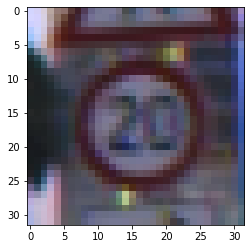

In [29]:

plt.imshow(x_test[990]) 
print("Predicted sign: "+ str( 
        final_model.predict(x_test_final[1700].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(final_model.predict(x_test_final[990].reshape(1, 32, 32, 1))))


### Save the model

In [30]:
final_model.save('/content/drive/My Drive/Image Classification/Model_CNN.hdf5')

### Loading the saved model 

In [31]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/Image Classification/Model_CNN.hdf5')

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 50)        500       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 50)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 108)       48708     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 108)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 108)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 41)          3

### Making predictions with the loaded model 

Predicted sign: [[9.8710196e-09 6.2009720e-05 6.8093481e-04 4.8590275e-05 6.5635533e-08
  9.9893981e-01 6.0154929e-07 2.6758516e-04 2.6459901e-07 4.2070200e-10
  4.4142499e-08 2.1236918e-12 4.7395959e-11 2.0905239e-12 9.6591166e-11
  9.8574731e-09 1.1827411e-08 1.5549336e-11 2.2984633e-15 7.8816199e-14
  1.2860215e-13 2.9954570e-12 4.6155483e-14 1.2959053e-13 3.0852992e-13
  6.7757367e-13 3.5113757e-15 5.0763670e-14 9.0866214e-13 5.5509760e-11
  2.7943450e-10 1.6059550e-11 5.4384192e-12 2.3468923e-11 2.3928759e-10
  9.5990512e-13 5.0066528e-14 4.9450808e-13 2.1673210e-09 2.1366567e-12
  5.5936582e-08 4.0188673e-12 1.8592539e-09]]
---------------------------------------------------------------------------
Predicted Sign[[9.8710196e-09 6.2009720e-05 6.8093481e-04 4.8590275e-05 6.5635533e-08
  9.9893981e-01 6.0154929e-07 2.6758516e-04 2.6459901e-07 4.2070200e-10
  4.4142499e-08 2.1236918e-12 4.7395959e-11 2.0905239e-12 9.6591166e-11
  9.8574731e-09 1.1827411e-08 1.5549336e-11 2.2984633e-1

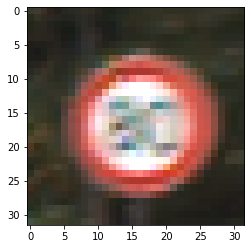

In [32]:
plt.imshow(x_test[1832]) 
print("Predicted sign: "+ str( 
        loaded_model.predict(x_test_final[1832].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(loaded_model.predict(x_test_final[1832].reshape(1, 32, 32, 1))))

### Testing our saved model on random traffic sign images





In [35]:
from tensorflow.keras.models import load_model

import cv2

import numpy as np

final_model = load_model('/content/drive/My Drive/Image Classification/Model_CNN.hdf5')

img = cv2.imread('/content/drive/My Drive/Image Classification/Test Images/test.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

img = img / 255

img = cv2.resize(img,(32,32))

img = np.reshape(img,[1,32,32,1])

classes = final_model.predict(img)

print(classes)

[[2.9919073e-17 4.2742503e-16 8.7884028e-18 1.0080345e-15 3.8167071e-13
  1.2312493e-16 3.6642674e-16 2.8086236e-16 4.3267601e-17 6.0730019e-19
  1.4663606e-14 2.0676923e-07 1.4355930e-17 2.1696641e-17 3.2200902e-16
  2.6628690e-14 1.1325290e-16 6.0689522e-18 9.9998772e-01 2.0248693e-10
  2.3120708e-11 1.2408301e-09 6.9628155e-14 1.8876763e-11 1.0656869e-06
  2.0467946e-12 2.7110227e-06 8.2146007e-06 3.8611603e-09 1.6418446e-11
  3.1609316e-11 3.5084600e-12 7.2502453e-17 3.8135215e-16 6.6794969e-16
  1.5598836e-12 1.6166906e-13 3.2690254e-14 3.1421524e-15 1.6951465e-17
  1.7852783e-14 8.7530419e-17 1.3297398e-16]]
